In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("HeartDataAnalysis").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/06 02:42:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
file1 = "heart.csv"
file2 = "heart2.csv"
df1 = spark.read.csv(file1, header=True, inferSchema=True)
df2 = spark.read.csv(file2, header=True, inferSchema=True)

In [4]:
df1.show()
df1.columns


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

In [5]:
df2.show()
df2.columns


+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|Age|Sex|Chest pain type| BP|Cholesterol|FBS over 120|EKG results|Max HR|Exercise angina|ST depression|Slope of ST|Number of vessels fluro|Thallium|Heart Disease|
+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
| 70|  1|              4|130|        322|           0|          2|   109|              0|          2.4|          2|                      3|       3|     Presence|
| 67|  0|              3|115|        564|           0|          2|   160|              0|          1.6|          2|                      0|       7|      Absence|
| 57|  1|              2|124|        261|           0|          0|   141|              0|          0.3|          1|                      0|       7|     Presence|
| 64|  1|             

['Age',
 'Sex',
 'Chest pain type',
 'BP',
 'Cholesterol',
 'FBS over 120',
 'EKG results',
 'Max HR',
 'Exercise angina',
 'ST depression',
 'Slope of ST',
 'Number of vessels fluro',
 'Thallium',
 'Heart Disease']

In [6]:
df2 = df2.withColumnRenamed("Chest pain type", "ChestPainType") \
         .withColumnRenamed("BP", "RestingBP") \
         .withColumnRenamed("FBS over 120", "FastingBS") \
         .withColumnRenamed("EKG results", "RestingECG") \
         .withColumnRenamed("Exercise angina", "ExerciseAngina") \
         .withColumnRenamed("Max HR", "MaxHR") \
         .withColumnRenamed("ST depression", "Oldpeak") \
         .withColumnRenamed("Slope of ST", "ST_Slope") \
         .withColumnRenamed("Heart Disease", "HeartDisease")

In [7]:
df1 = df1.withColumn("Sex", F.when(F.col("Sex") == "M", 1).otherwise(0))

df1 = df1.withColumn("ChestPainType", 
                     F.when(F.col("ChestPainType") == "TA", 1)
                     .when(F.col("ChestPainType") == "ATA", 2)
                     .when(F.col("ChestPainType") == "NAP", 3)
                     .otherwise(4))

df1 = df1.withColumn("FastingBS", F.when(F.col("FastingBS") == 1, 1).otherwise(0))

df1 = df1.withColumn("RestingECG", 
                     F.when(F.col("RestingECG") == "Normal", 0)
                     .when(F.col("RestingECG") == "ST", 1)
                     .otherwise(2))

df1 = df1.withColumn("ExerciseAngina", F.when(F.col("ExerciseAngina") == "Y", 1).otherwise(0))

df1 = df1.withColumn("ST_Slope", 
                     F.when(F.col("ST_Slope") == "Up", 1)
                     .when(F.col("ST_Slope") == "Flat", 2)
                     .otherwise(3))

df2 = df2.withColumn("HeartDisease", 
                     F.when(F.col("HeartDisease") == "Absence", 0)
                     .otherwise(1))

In [8]:
columns_to_drop = ["Number of vessels fluro", "Thallium"]
df2 = df2.drop(*columns_to_drop)

In [9]:
df_merged = df1.union(df2)


In [10]:
df_merged.show()
df_merged.printSchema()


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  1|            2|      140|        289|        0|         0|  172|             0|    0.0|       1|           0|
| 49|  0|            3|      160|        180|        0|         0|  156|             0|    1.0|       2|           1|
| 37|  1|            2|      130|        283|        0|         1|   98|             0|    0.0|       1|           0|
| 48|  0|            4|      138|        214|        0|         0|  108|             1|    1.5|       2|           1|
| 54|  1|            3|      150|        195|        0|         0|  122|             0|    0.0|       1|           0|
| 39|  1|            3|      120|        339|        0| 

In [11]:
df_merged.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- ChestPainType: integer (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: integer (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: integer (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: integer (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [12]:
df_merged.filter(df_merged["RestingBP"] == 0).count()


1

+-------+------------------+
|summary|       Cholesterol|
+-------+------------------+
|  count|              1188|
|   mean|210.35858585858585|
| stddev|101.50556295703767|
|    min|                 0|
|    max|               603|
+-------+------------------+



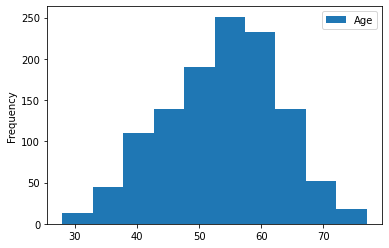

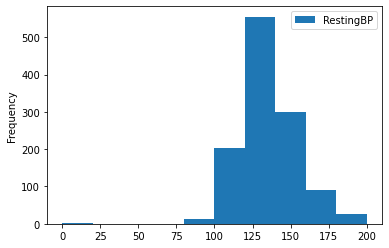

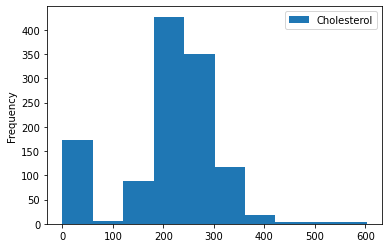

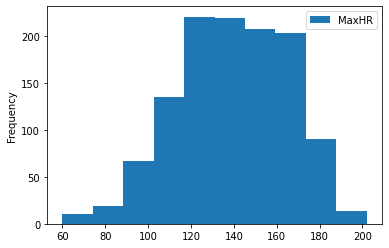

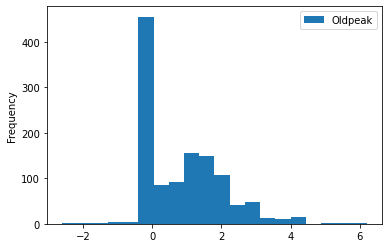

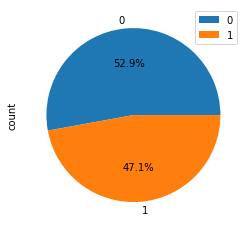

In [13]:
df_merged.select("Age").toPandas().plot.hist()
df_merged.select("RestingBP").toPandas().plot.hist()
df_merged.select("Cholesterol").toPandas().plot.hist()
df_merged.select("MaxHR").toPandas().plot.hist()
df_merged.select("Oldpeak").toPandas().plot.hist(bins=20)
df_merged.groupBy("HeartDisease").count().toPandas().plot.pie(y="count", autopct="%1.1f%%")
df_merged.select("Cholesterol").describe().show()

In [14]:
null_counts = df_merged.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_merged.columns])
null_counts.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



<AxesSubplot:>

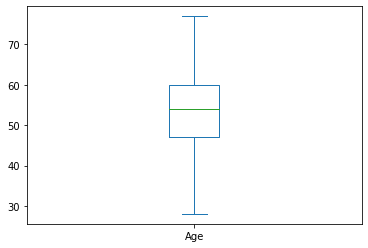

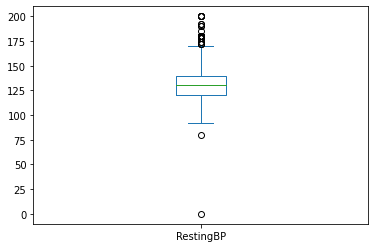

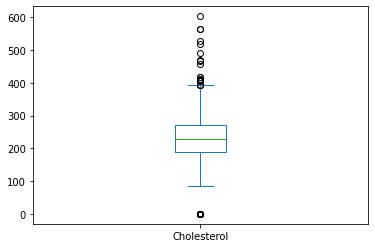

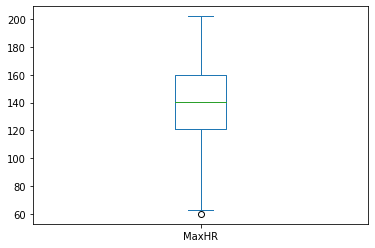

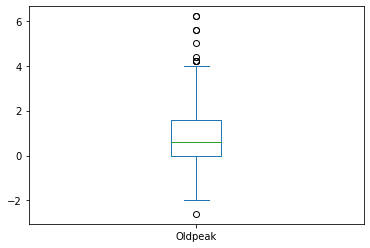

In [15]:
df_merged.select("Age").toPandas().plot.box()
df_merged.select("RestingBP").toPandas().plot.box()
df_merged.select("Cholesterol").toPandas().plot.box()
df_merged.select("MaxHR").toPandas().plot.box()
df_merged.select("Oldpeak").toPandas().plot.box()

In [16]:
df_filtered = df_merged.filter(df_merged['RestingBP'] != 0)
df_filtered.filter(df_merged["RestingBP"] == 0).count()

0

In [17]:
non_zero_cholesterol = df_filtered.filter(df_filtered['Cholesterol'] != 0)
chol_median = non_zero_cholesterol.approxQuantile(col='Cholesterol',probabilities=[0.5,],relativeError=0)
chol_median[0]

240.0

In [18]:
from pyspark.sql.functions import when
df_filtered = df_filtered.withColumn('Cholesterol', when(df_filtered['Cholesterol'] == 0, chol_median[0]).otherwise(df_filtered['Cholesterol']))

<AxesSubplot:ylabel='Frequency'>

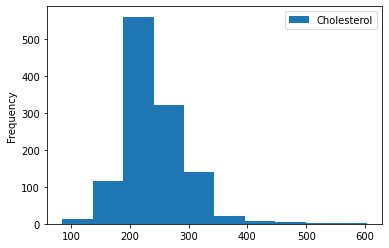

In [19]:
df_filtered.select("Cholesterol").toPandas().plot.hist()

In [20]:
df_filtered = df_filtered.withColumn(
    'BPtype',
    when(col('RestingBP') <= 120, 0)
    .when((col('RestingBP') > 120) & (col('RestingBP') <= 139), 1)
    .otherwise(2)
)
df_filtered = df_filtered.drop('RestingBP')

In [21]:
df_filtered = df_filtered.withColumn('Age_Cholesterol_rate', col('Cholesterol') * col('Age'))

In [22]:
df_filtered.show()

+---+---+-------------+-----------+---------+----------+-----+--------------+-------+--------+------------+------+--------------------+
|Age|Sex|ChestPainType|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|BPtype|Age_Cholesterol_rate|
+---+---+-------------+-----------+---------+----------+-----+--------------+-------+--------+------------+------+--------------------+
| 40|  1|            2|      289.0|        0|         0|  172|             0|    0.0|       1|           0|     2|             11560.0|
| 49|  0|            3|      180.0|        0|         0|  156|             0|    1.0|       2|           1|     2|              8820.0|
| 37|  1|            2|      283.0|        0|         1|   98|             0|    0.0|       1|           0|     1|             10471.0|
| 48|  0|            4|      214.0|        0|         0|  108|             1|    1.5|       2|           1|     1|             10272.0|
| 54|  1|            3|      195.0|        0|   

In [34]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer,VectorSlicer
from pyspark.sql.functions import udf
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.sql.types import ArrayType,FloatType, DoubleType, IntegerType


In [35]:

categorical_columns = ['ChestPainType', 'ST_Slope']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_filtered) for column in categorical_columns]
encoders = [OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[col + "_vec"],dropLast=True) for indexer, col in zip(indexers, categorical_columns)]


In [36]:
print(indexers[0].labels)

['4', '3', '2', '1']


In [37]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + encoders)
df_encoded = pipeline.fit(df_filtered).transform(df_filtered)
selected_cols = [column + "_vec" for column in categorical_columns] + df_filtered.columns
df_encoded = df_encoded.select(selected_cols)

In [38]:
def vector_to_list(v):
    if isinstance(v, SparseVector):
        v = DenseVector(v)
    return v.toArray().tolist()

vector_to_list_udf = udf(vector_to_list, ArrayType(DoubleType()))

In [39]:
for column in ['ChestPainType_vec', 'ST_Slope_vec']:
    df_encoded = df_encoded.withColumn(column+"_list", vector_to_list_udf(col(column)))
    num_categories = len(df_encoded.select(column).first()[0])
    # Extract individual columns from list
    for i in range(num_categories):
        df_encoded = df_encoded.withColumn(column+"_"+str(i), col(column+"_list")[i])

In [40]:
df_encoded.columns

['ChestPainType_vec',
 'ST_Slope_vec',
 'Age',
 'Sex',
 'ChestPainType',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease',
 'BPtype',
 'Age_Cholesterol_rate',
 'ChestPainType_vec_list',
 'ChestPainType_vec_0',
 'ChestPainType_vec_1',
 'ChestPainType_vec_2',
 'ST_Slope_vec_list',
 'ST_Slope_vec_0',
 'ST_Slope_vec_1']

In [41]:
Columns_to_drop2 =["ChestPainType",'ST_Slope','ChestPainType_vec_list', 'ST_Slope_vec_list','ChestPainType_vec','ST_Slope_vec',]
df_encoded=df_encoded.drop(*Columns_to_drop2)


In [42]:

correlations = {}
for column in df_encoded.columns:
    if column != 'HeartDisease' and isinstance(df_encoded.schema[column].dataType, (FloatType, DoubleType, IntegerType)):
        corr_value = df_encoded.stat.corr(column, 'HeartDisease')
        correlations[column] = corr_value
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
sorted_correlations

[('ChestPainType_vec_0', 0.5166678619757027),
 ('ST_Slope_vec_0', 0.5101184268398316),
 ('ExerciseAngina', 0.48155609793226906),
 ('Oldpeak', 0.3986584915876416),
 ('Sex', 0.30966378262586897),
 ('Age', 0.2614804309278609),
 ('FastingBS', 0.21739936041252822),
 ('Age_Cholesterol_rate', 0.20662252279117013),
 ('BPtype', 0.12170140121918528),
 ('Cholesterol', 0.08626636227703617),
 ('RestingECG', 0.0728399082296723),
 ('ChestPainType_vec_1', -0.23991745322997685),
 ('ChestPainType_vec_2', -0.36181067851086307),
 ('MaxHR', -0.41317265635360617),
 ('ST_Slope_vec_1', -0.5685304729033728)]

In [43]:
columns_drop3 = ['Cholesterol','RestingECG','BPtype']
df3 = df_encoded.drop(*columns_drop3)
df3.columns

['Age',
 'Sex',
 'FastingBS',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'HeartDisease',
 'Age_Cholesterol_rate',
 'ChestPainType_vec_0',
 'ChestPainType_vec_1',
 'ChestPainType_vec_2',
 'ST_Slope_vec_0',
 'ST_Slope_vec_1']

+------------+-----+
|HeartDisease|count|
+------------+-----+
|           1|  627|
|           0|  632|
+------------+-----+



<AxesSubplot:ylabel='count'>

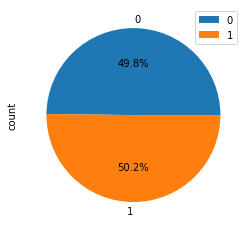

In [44]:
df3_low = df3.filter(col('HeartDisease') == 0)
df3_high = df3.filter(col('HeartDisease') == 1)
num_low = df3_low.count()
num_high = df3_high.count()

df3_low_boosted = df3_low.sample(withReplacement=True, fraction=num_high/num_low)
df3_boosted = df3_high.union(df3_low_boosted)
df3_boosted.groupBy("HeartDisease").count().show()
df4 = df3_boosted

df4.groupBy("HeartDisease").count().toPandas().plot.pie(y="count", autopct="%1.1f%%")

<AxesSubplot:ylabel='Frequency'>

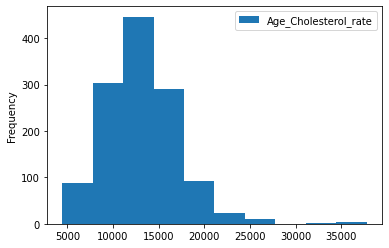

In [45]:
df4.select("Age_Cholesterol_rate").toPandas().plot.hist()

In [53]:
from pyspark.sql.functions import log
df_with_log = df4.withColumn("log_Age_Cholesterol_rate", log(col("Age_Cholesterol_rate")))
df5 = df_with_log

<AxesSubplot:ylabel='Frequency'>

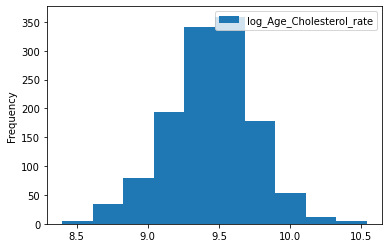

In [55]:
df5.select("log_Age_Cholesterol_rate").toPandas().plot.hist()